**Importing Section**

In [ ]:
import numpy as np
import os
import pandas as pd
import torch

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers

In [ ]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


**Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Initializing The Path Folders of train, test, validation directories.**


In [ ]:
train_directory      = "/content/drive/MyDrive/Research/TrashNet/train"
test_directory       = "/content/drive/MyDrive/Research/TrashNet/test"
validation_directory = "/content/drive/MyDrive/Research/TrashNet/validation"

In [ ]:
import tensorflow as tf
import keras
print(tf.__version__)

2.8.2


**Creating a VGG16 Model**

In [ ]:
image_size = [128, 128]
batch_size = 32
model1 = VGG16(include_top= False, input_shape=image_size+[3])

58900480/58889256 [==============================] - 0s 0us/step


**Generating Batches of tensor image data with real-time image augmentation**

In [ ]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range=45,
)

datagen_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255) #rescaling/normalizing value between 1 and 0

datagen_validation = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_generator = datagen_train.flow_from_directory(
    directory = train_directory,
    target_size = image_size,
    batch_size = batch_size,
    shuffle = True
    )

test_generator = datagen_test.flow_from_directory(
    directory = test_directory,
    target_size = image_size,
    batch_size = batch_size,
    shuffle = True
    )

validation_generator = datagen_validation.flow_from_directory(
    directory = validation_directory,
    target_size = image_size,
    batch_size = batch_size,
    shuffle = True
    )

Found 1770 images belonging to 6 classes.
Found 518 images belonging to 6 classes.
Found 239 images belonging to 6 classes.


**Adding Flatten and Dense Layers**

In [ ]:
headModel = model1.output
headModel = layers.Flatten()(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(6, activation="softmax")(headModel)
model = Model(inputs=model1.input, outputs=headModel, name='VGG16')

**Adding Optimizer**

In [ ]:
optimizer = Adam(lr=1e-5)
loss      = 'categorical_crossentropy'
metrics   = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [ ]:
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

**Google Drive Checkpoint**

In [ ]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(
    monitor = 'val_loss', min_delta = 0, 
    patience = 10, verbose = 1, mode = 'min'
)

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
checkpoint_path = "training_1/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
my_callbacks = [cp_callback, earlystop]

**Simulating Epochs**

In [ ]:
epochs = 100


history = model.fit(
    train_generator,
    epochs = epochs, 
    validation_data = validation_generator,
    callbacks = my_callbacks
)



Epoch 1/100
56/56 [==============================] - ETA: 0s - loss: 2.1872 - accuracy: 0.1780 - precision: 0.1651 - recall: 0.0492
Epoch 1: saving model to training_1/cp.ckpt
56/56 [==============================] - 648s 11s/step - loss: 2.1872 - accuracy: 0.1780 - precision: 0.1651 - recall: 0.0492 - val_loss: 1.6198 - val_accuracy: 0.3933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 1.8344 - accuracy: 0.2870 - precision: 0.3727 - recall: 0.1124
Epoch 2: saving model to training_1/cp.ckpt
56/56 [==============================] - 18s 324ms/step - loss: 1.8344 - accuracy: 0.2870 - precision: 0.3727 - recall: 0.1124 - val_loss: 1.4526 - val_accuracy: 0.5063 - val_precision: 0.8333 - val_recall: 0.0628
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 1.5991 - accuracy: 0.3763 - precision: 0.5276 - recall: 0.2107
Epoch 3: saving model to training_1/cp.ckpt
56/56 [==============================

In [ ]:
model.save('VGG16_20epochs.h5')

**Plotting and Graph**

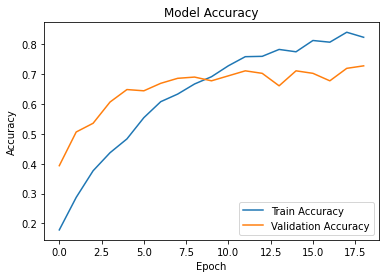

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train Accuracy","Validation Accuracy"], loc = 'lower right')
plt.show()

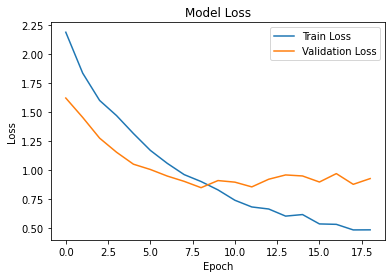

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss","Validation Loss"], loc = 'upper right')
plt.show()

**Prediction Test**

In [ ]:
finaltestCNV_dir = test_directory
datagen_finaltestCNV_dir = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

generator_finaltestCNV_dir = datagen_finaltestCNV_dir.flow_from_directory(directory=finaltestCNV_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  shuffle=False)
steps_finaltestCNV_dir = generator_finaltestCNV_dir.n / batch_size

y_pred = model.predict_generator(generator_finaltestCNV_dir,steps = steps_finaltestCNV_dir)
y_pred

Found 518 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


array([[1.000e+00, 7.272e-06, 4.035e-05, 1.253e-04, 8.047e-06, 2.450e-05],
       [1.000e+00, 8.047e-06, 6.372e-05, 7.331e-05, 7.331e-06, 2.044e-05],
       [9.995e-01, 6.378e-06, 2.968e-05, 3.145e-04, 1.538e-05, 4.518e-05],
       ...,
       [1.678e-02, 2.690e-01, 3.604e-02, 7.666e-02, 1.713e-01, 4.304e-01],
       [2.106e-02, 2.451e-02, 7.062e-02, 3.948e-01, 2.013e-02, 4.688e-01],
       [4.053e-02, 2.603e-02, 7.684e-02, 1.946e-01, 1.717e-02, 6.450e-01]],
      dtype=float16)

In [ ]:
predicted_class_indices=np.argmax(y_pred,axis=1)
print(predicted_class_indices)

[0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 3 3
 0 0 0 0 0 0 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 5 1 2 1 2 1 2 2 2 1 1 1 1 1 2 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 4 1 1 1 2 1 2 2 2 2 2
 2 2 5 3 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 0 2 3 2 2 2 2 2 2 0 2
 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 4 2 1 2 2 2 2 2 2 2 2 2
 2 2 1 2 2 4 2 2 2 2 2 3 3 3 3 0 3 3 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3
 1 3 5 3 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 4 4 1 4 2 1 4 2 4 4 4 3 4 4 4 4 1
 4 4 4 1 4 4 2 4 4 4 2 2 4 1 4 4 4 2 4 4 4 4 5 4 4 1 4 1 4 4 4 1 4 1 4 4 4
 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 1 4 4 4 4 4 4 4 4 4 2 4 2 4 4 4
 4 2 4 1 4 4 4 4 4 5 5 1 

**Adding Lebel on Test Image**

In [ ]:
test_label = []
cardboardLabel = 0
glassLabel = 1
metalLabel = 2
paperLabel = 3
plasticLabel = 4
trashLabel = 5


for i in range(80):
    test_label.append(cardboardLabel)

for i in range(100):
    test_label.append(glassLabel)

for i in range(90):
    test_label.append(metalLabel)

for i in range(120):
    test_label.append(paperLabel)

for i in range(100):
    test_label.append(plasticLabel)

for i in range(28):
    test_label.append(trashLabel)





print(test_label)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import itertools

In [ ]:
array = confusion_matrix(test_label, predicted_class_indices)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#Print Classification Report

print('Classification Report')
print(classification_report(test_label, predicted_class_indices, target_names=["carboard", "glass","metal","paper","plastic","trash"]))

Classification Report
              precision    recall  f1-score   support

    carboard       0.91      0.93      0.92        80
       glass       0.81      0.84      0.82       100
       metal       0.75      0.84      0.79        90
       paper       0.89      0.93      0.91       120
     plastic       0.93      0.76      0.84       100
       trash       0.67      0.57      0.62        28

    accuracy                           0.84       518
   macro avg       0.82      0.81      0.82       518
weighted avg       0.85      0.84      0.84       518



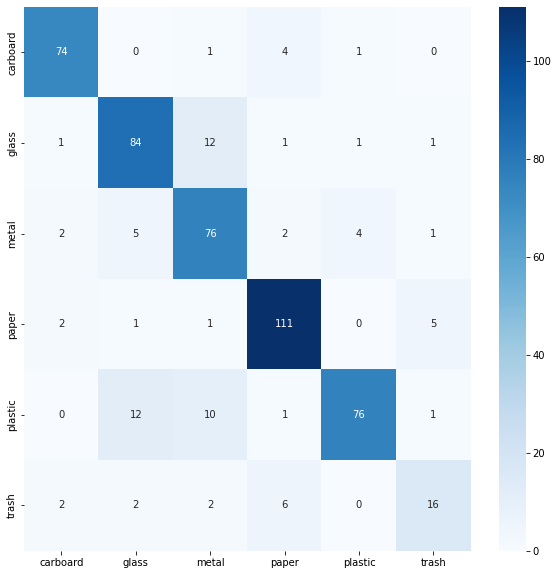

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(array, index = ["carboard", "glass","metal","paper","plastic","trash"],
                  columns = ["carboard", "glass","metal","paper","plastic","trash"])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')